In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

---
### Checking GPU Availability
---

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

---
### Importing Data
---

In [4]:
X = np.load('./storage/1yeardata/X.npy')
data = pd.read_pickle('./storage/1yeardata/data.pickle')
meta = pd.read_pickle('./storage/1yeardata/meta.pickle')

In [5]:
print(data.shape)
print(meta.shape)
print(X.shape)

(1616, 6986)
(499, 3)
(499, 1616, 14)


In [6]:
#lets get all gics sector names in a list (for later use)
sector_tags = []
for j in meta['GICS Sector']:
    if j not in sector_tags:
        sector_tags.append(j)

In [7]:
sector_tags

['Industrials',
 'Health Care',
 'Information Technology',
 'Communication Services',
 'Consumer Discretionary',
 'Utilities',
 'Financials',
 'Materials',
 'Real Estate',
 'Consumer Staples',
 'Energy']

---
### Setting GICS Sector
---

In [ ]:
#getting all the tickers in a specific sector, subind likely wont be used until post-analysis
#this begs the question, why sector training? Because it necessitates "batch" coding
sector_ticks = []
gics_sector = 'Energy'
for j in meta.values:
    if j[1] == gics_sector:
        sector_ticks.append(j[0])

In [ ]:
#visualizing sector stocks
for j in sector_ticks:
    print(meta[meta.Ticker == j])

In [ ]:
#Variables that need to be defined

window_len = 5 #daily rows; val of 5 looks back on 5 days worth of trading data
n_features = X.shape[2] #for later on / = 14
num_times_train = X.shape[1] - 7*5 #how many time rows used for training **NOT ROLLING WINDOW BATCH NUMBER** that's less than this number by 'window_len'
#this above number needed for scaling processes mostly

In [ ]:
print(len(sector_ticks))
for j in sector_ticks:
    plt.plot(data[j]['Close'])
    plt.title(gics_sector +' Sector Close')
    plt.grid('on')
    plt.xlim(data.index[0],data.index[-1])

---
### Preprocessing
---

In [ ]:
#X numpy structure:
#X[Ticker # corresponded with meta index (499 of these)][datetime index # (X of these)][OHLC/Tis]
X = X.astype('float32')

#need to make a for loop that scales every ticker in sector_ticks and puts it into a dict with each ticker corresponding to arr of dimension (num_times_train, n_features)
X_scaled = {}
x_forecasteval = {}
#where do i store scalers? in a dictionary!
scalers = {}

for j in sector_ticks:
    index = meta.loc[meta['Ticker'] == j].index[0]
    X_sectick = X[index]

    #x_realpredicted is just for forecast evaluation purposes/those 5 days ahead that we are comparing our forecasts on, kind of like test data but not really
    x_forecasteval[j] = X_sectick[-7*5:,0]

    X_sectick = X_sectick[:-35]

    scalers[j] = StandardScaler()
    scalers[j] = scalers[j].fit(X_sectick)
    X_sectick_scaled = scalers[j].transform(X_sectick)
    #for when we have to invert predictions
    #X_AAPL_inverted = scaler.inverse_transform(X_AAPL_scaled)

    X_scaled[j] = X_sectick_scaled


In [ ]:
#now let's prepare our rolling windows, for an entire sector.. we work with another dict with 3 dimensional arrays in each ticker
x_train = {}
rollin_samps = num_times_train-window_len+1
for j in X_scaled.keys():
  x_train[j] = np.zeros((rollin_samps,window_len,n_features))
  for i in range(rollin_samps):
    x_train[j][i] = X_scaled[j][i:i+window_len,:]

In [ ]:
#lets save our last datum in each ticker into own dict to save for forecast data later on
x_forecastdata = {}
for j in sector_ticks:
    x_forecastdata[j] = x_train[j][-1]

---
### Network Functions
---

In [ ]:
def discriminator(in_shape,lr):
  inputs = Input(shape=(in_shape))
  d1 = Dense(64)(inputs)
  LR1 = LeakyReLU()(d1)
  d2 = Dense(16)(LR1)
  LR2 = LeakyReLU()(d2)
  outputs = Dense(1,activation='sigmoid')(LR2)
  model_D = keras.Model(inputs=inputs, outputs=outputs, name='discriminator')

  opt=Adam(lr=lr)
  model_D.compile(loss='binary_crossentropy',optimizer=opt)
  return model_D

In [ ]:
def generator(in_shape,out_dim,neurons_lstm):
  inputs = Input(in_shape,name='window_input')
  LSTM1 = LSTM(neurons_lstm,input_shape=in_shape,return_sequences=False)(inputs)
  DO1 = Dropout(0.5)(LSTM1)
  #LSTM2 = LSTM(neurons_lstm,input_shape=in_shape,return_sequences=False)(DO1)
  #DO2 = Dropout(0.5)(LSTM2)
  D1 = Dense(out_dim)(DO1)
  LR = LeakyReLU()(D1)
  outputs = Reshape((1,out_dim))(LR)
  model_G = keras.Model(inputs=inputs,outputs=outputs,name='generator')

  return model_G

In [ ]:
def gan_model(model_D, model_G,gen_input_shape, lr, lossweights):
  model_D.trainable = False
  ins = Input((gen_input_shape))
  predicted = model_G(ins)
  #concat with ins
  predicted_concat = concatenate([ins,predicted],axis=1)
  #print(predicted_concat.shape)
  outs = model_D(predicted_concat)
  model_GAN = keras.Model(inputs=ins,outputs=outs,name='GAN')

  opt = Adam(lr=lr)
  model_GAN.compile(loss=['binary_crossentropy','mean_squared_error'],loss_weights=lossweights ,optimizer=opt)
  return model_GAN

---
### Training Functions
---

In [ ]:
#not used in LSTM-GAN
def noise_vector(latent_dim, batch_size):
  noise = np.random.randn(latent_dim * batch_size)
  noise = np.reshape(noise, (batch_size,1, latent_dim))
  return noise

In [ ]:
def generated_sample(window_data, model):
  #latent_space = noise_vector(latent_dim, batch_size)
  window_data = window_data[np.newaxis,:,:]
  x_predicted = model.predict(window_data)
  x_fake = np.concatenate((window_data,x_predicted),axis=1)
  y_fake = np.zeros((1,1))
  return x_fake, y_fake

In [ ]:
def real_sample(window_data, lookahead_data):
  lookahead_data = lookahead_data[-1,:]
  lookahead_data = lookahead_data[np.newaxis,:]
  x_real = np.concatenate((window_data,lookahead_data),axis=0)
  x_real = x_real[np.newaxis,:,:]
  y_real = np.ones((1,1))
  return x_real, y_real

In [ ]:
def train(model_D,model_G,model_GAN, dataset,ticker, epochs=1):
  global generator_loss, discriminator_loss
  generator_loss[ticker] = []
  discriminator_loss[ticker] = []
  for j in range(epochs):
    for i in range(dataset.shape[0]-1): 
      #start with discriminator training:
      X_real, y_real = real_sample(dataset[i],dataset[i+1])
      X_fake, y_fake = generated_sample(dataset[i],model_G) 
      X, y = np.vstack((X_real,X_fake)), np.vstack((y_real,y_fake))
      
      disc_loss = model_D.train_on_batch(X,y)
      
      #adversarial training
      X_GAN = dataset[i]
      X_GAN = X_GAN[np.newaxis,:,:]
      y_GAN = np.ones((1,1))
      
      GAN_loss = model_GAN.train_on_batch(X_GAN,y_GAN)
      
      generator_loss[ticker].append(GAN_loss)
      discriminator_loss[ticker].append(disc_loss)

      #if (i % 100) == 0:
        #print('>%d:%d, disc_loss=%.4f, GAN_loss=%.4f' % (j+1,i,disc_loss,GAN_loss))
      
    #print('>%d,  disc_loss=%.4f , GAN_loss=%.4f' % (j+1,disc_loss,GAN_loss))

---
### Training
---

In [ ]:
disc_input_shape = (6,n_features)
gen_input_shape = (window_len,n_features)
loss_weights = [0.5,0.5]
gan_learning_rate = 1e-3
disc_learning_rate = 1e-3
lstm_neurons = 16

epochs=5

generator_loss = {}
discriminator_loss = {}

disc_models = {}
gen_models = {}
GAN_models = {}

now = dt.datetime.now()
now = now.strftime('%Y-%m-%d_%H-%M-%S')
i=1
print('>>Starting ' + gics_sector + ' Training . . .')
#wall time for entire sector
start = time.time()
for j in x_train.keys():
    disc_models[j] = discriminator(disc_input_shape,disc_learning_rate)
    gen_models[j] = generator(gen_input_shape,n_features,lstm_neurons)
    GAN_models[j] = gan_model(disc_models[j],gen_models[j],gen_input_shape,gan_learning_rate,loss_weights)
    
    train(disc_models[j], gen_models[j], GAN_models[j], dataset=x_train[j] , ticker=j , epochs=epochs)
    print('>>%d ticker(s) completed' % (i))
    i += 1
    
end = str(dt.timedelta(seconds=(round(time.time() - start))))
#playsound('narration.mp3')

---
### Visualizations
---

In [ ]:
#take first key in x_train as part of example visualizations
key = list(x_train.keys())[0]

In [ ]:
#any one of models work for this part since its just architecture showcase
plot_model(GAN_models[key],show_shapes=True,show_layer_names=True,to_file='storage/architectures/ganarchs/gan_arch_%s.png' % (now))
plot_model(disc_models[key],show_shapes=True,show_layer_names=True,to_file='storage/architectures/discarchs/disc_arch_%s.png' % (now))
plot_model(gen_models[key],show_shapes=True,show_layer_names=True,to_file='storage/architectures/genarchs/gen_arch_%s.png' % (now))
img_disc = mpimg.imread('storage/architectures/discarchs/disc_arch_%s.png' % (now))
img_gen = mpimg.imread('storage/architectures/genarchs/gen_arch_%s.png' % (now))
img_gan = mpimg.imread('storage/architectures/ganarchs/gan_arch_%s.png' % (now))

In [31]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'w',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'a

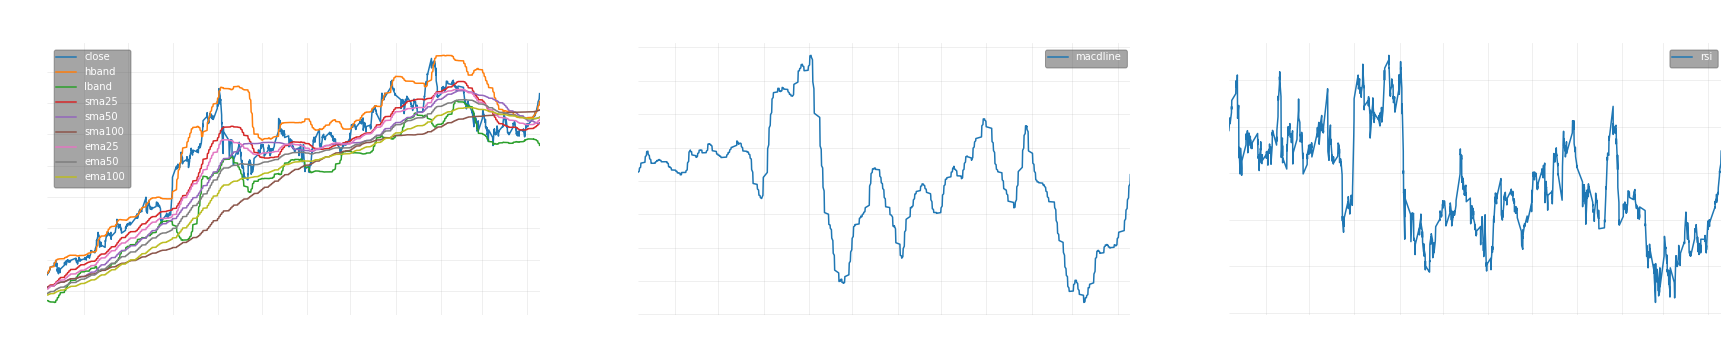

In [57]:
#example visualization of aapl TIs
vszn_data = data['AAPL']
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(131)
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : (1,1,1,0),
          'text.color' : 'w',
          'legend.facecolor': (1,1,1,0),
          'legend.edgecolor': '0',
          'legend.framealpha': '0',
          'legend.shadow' : True,
          'axes.facecolor' : (1,1,1,0),
          'grid.alpha': '.25',
          'grid.color': '#b0b0b0',}
plt.rcParams.update(params)
fig.suptitle('AAPL Tech. Indicators',fontsize='xx-large',y=.98)
plt.plot(vszn_data['Close'])
plt.plot(vszn_data['H_BAND'])
plt.plot(vszn_data['L_BAND'])
plt.plot(vszn_data['SMA25'])
plt.plot(vszn_data['SMA50'])
plt.plot(vszn_data['SMA100'])
plt.plot(vszn_data['EMA25'])
plt.plot(vszn_data['EMA50'])
plt.plot(vszn_data['EMA100'])
plt.legend(['close','hband','lband','sma25','sma50','sma100','ema25','ema50','ema100'])
plt.grid('on')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.xlim(vszn_data['Close'].index[0],vszn_data['Close'].index[-1])
ax2 = fig.add_subplot(132)
plt.plot(vszn_data['MACD'])
plt.xlabel('Date')
plt.grid('on')
plt.xlim(vszn_data['Close'].index[0],vszn_data['Close'].index[-1])
plt.legend(['macdline'])
ax3 = fig.add_subplot(133)
plt.plot(vszn_data['RSI'])
plt.ylabel('Percent (%)')
plt.xlabel('Date')
plt.legend(['rsi'])
plt.grid('on')
plt.xlim(vszn_data['Close'].index[0],vszn_data['Close'].index[-1])
fname = 'storage/ti/ti.png'
plt.savefig(fname,bbox_inches = 'tight')

In [ ]:
text = 'Features Included: %d\n\nEpochs: %d\nLSTM Neurons: %d\nDiscriminator LR: %.4f\nGAN LR: %.4f\nGAN Loss Weights (BCE,MSE): [%.1f,%.1f]\n\nTraining Wall Time: %s' % (n_features,epochs,lstm_neurons,disc_learning_rate,gan_learning_rate,loss_weights[0],loss_weights[1],end)

gs = gridspec.GridSpec(3,6)
gs.update(wspace=0.45,hspace=.25)
plt.figure(figsize=(10,15))
ax1 = plt.subplot(gs[0,:2],)
plt.title('Generator Architecture')
plt.imshow(img_gen)
plt.axis('off')
ax2 = plt.subplot(gs[0,2:4],)
plt.title('Discriminator Architecture')
plt.imshow(img_disc)
plt.axis('off')
ax7 = plt.subplot(gs[0,4:],)
plt.title('GAN Architecture')
plt.imshow(img_gan)
plt.axis('off')
ax3 = plt.subplot(gs[2,:4],)
plt.title('Training Set Predictions: ' + key +' Close 2020-2021')
plt.plot(real_close)
plt.plot(predictions_close)
plt.legend(['Close','Predictions'])
plt.xlabel('Trading Hours')
ax4 = plt.subplot(gs[2,4:],)
plt.axis('off')
plt.text(0.0,0.35,s=text)
ax5 = plt.subplot(gs[1,:3],)
plt.plot(generator_loss[key])
plt.xlabel('Inputs')
plt.title('Generator Loss')
ax6 = plt.subplot(gs[1,3:],)
plt.plot(discriminator_loss[key])
plt.xlabel('Inputs')
plt.title('Discriminator Loss')
fname = 'storage/combined_summaries/Summary_%s_.png' % (now)
plt.savefig(fname,facecolor='white',bbox_inches = 'tight')

---
### Directory Creations
---

In [ ]:
#because of below issue, need to do a one-time directory creation loop for IT sector, something like /storage/models/sectors/IT/(all tickers)/(disc/gen/gan)/final location
#do this one at a time, so first, create all the folders in /sectors/ then do all the tickers in /Information Technology/ then (disc/gen/gan) in each ticker
#using os.mkdir

'''
for j in sector_tags:
    path = os.path.join('./storage/sector_resources',j)
    os.mkdir(path=path)

'''
#now create all tick dirs in /sectors/gics_sector using sector_ticks

for j in sector_ticks:
    path = './storage/models/sectors/'+ gics_sector + '/' + j
    os.mkdir(path=path)

#now create disc/gen/gan dirs in each ticker

for j in sector_ticks:
    pathdisc = './storage/models/sectors/' + gics_sector + '/' + j + '/disc'
    pathgen = './storage/models/sectors/' + gics_sector + '/' + j + '/gen'
    pathgan = './storage/models/sectors/' + gics_sector + '/' + j + '/gan'
    os.mkdir(pathdisc)
    os.mkdir(pathgen)
    os.mkdir(pathgan)


---
### Saving
---

In [ ]:
#saving forecastevals
pickle_out = open('./storage/sector_resources/' + gics_sector + '/forecasteval.pickle','wb')
pickle.dump(x_forecasteval,pickle_out)
pickle_out.close()

#saving forecastdata
pickle_out = open('./storage/sector_resources/' + gics_sector + '/forecastdata.pickle','wb')
pickle.dump(x_forecastdata,pickle_out)
pickle_out.close()

#saving scalers
pickle_out = open('./storage/sector_resources/' + gics_sector + '/scaler.pickle','wb')
pickle.dump(scalers,pickle_out)
pickle_out.close()

print('Sector Resources of ' + gics_sector + ' completed.')

In [ ]:
#savings models
for j in sector_ticks:
    disc_models[j].save('storage/models/sectors/' + gics_sector + '/' + j + '/disc/model_discriminator_%s' % (now),save_format="h5")
    gen_models[j].save('storage/models/sectors/' + gics_sector + '/' + j + '/gen/model_generator_%s' % (now),save_format="h5")
    GAN_models[j].save('storage/models/sectors/' + gics_sector + '/' + j + '/gan/model_GAN_%s' % (now),save_format="h5")

---
### Loading
---

In [ ]:
#loading dict sector forecastevals
pickle_in = open('./storage/sector_resources/' + gics_sector + '/forecasteval.pickle','rb')
imptd_forecasteval = pickle.load(pickle_in)

#loading dict sector forecastdata
pickle_in = open('./storage/sector_resources/' + gics_sector + '/forecastdata.pickle','rb')
imptd_forecastdata = pickle.load(pickle_in)

#loading dict sector scalers
pickle_in = open('./storage/sector_resources/' + gics_sector + '/scaler.pickle','rb')
imptd_scalers = pickle.load(pickle_in)

In [ ]:
#loading dict gen models
ToT = '2021-04-14_09-59-34' # time string after model names/serves as a sort of 2FA for importing the correct models
imptd_sector_generators = {}
for j in sector_ticks:
    imptd_sector_generators[j] = tf.keras.models.load_model('storage/models/sectors/' + gics_sector + '/' + j + '/gen/model_generator_%s' % (ToT),compile=False)
    print('>>' + j + ' loaded')

---
### Forecasting Ahead
---

In [ ]:
# a function that uses the same scaler used to transform the data, back to its original scaling (prices) by concatenating the data we want transformed
# back to its original shape with a bunch of meaningless data (in this case, zeros)
def inverse_and_supply(data,scaler):
    inverted = np.concatenate((data,np.zeros((num_times_train-window_len+1,n_features))))
    inverted = scaler.inverse_transform(inverted)
    return inverted[0]

In [ ]:
# a function that just tries to estimate better trend slopes by multiplying current trend by (its current close price / sum of all the close prices in that sub industry)
# the format of this 'array' input: 1st column is trend/slope, 2nd column is last close price witnessed, 3rd column, is final weighted trend/slope
def weighted_trend(array):
    closing_sum = sum(array[:,1])
    array[:,2] = (array[:,1] / closing_sum) * array[:,0]
    weighted = sum(array[:,2])
    return weighted

In [ ]:
#creates a copy of the imported forecastdata which is just the last sample in the training dataset not used
rolling_forecastdata = dict(imptd_forecastdata)
#new dict for predicted values
predicted = {}
for j in sector_ticks:
    for i in range(window_len):
        #create empty appendable array in each key within predicted
        if j not in predicted.keys():
            predicted[j] = np.empty((0,n_features))
        #generate a sample by inputting the current sample in rolling forecastdata and the model necessary to predict on this ticker
        temp,_ = generated_sample(rolling_forecastdata[j], imptd_sector_generators[j])

        # append to the empty array with a row vector corresponding to the prediction. temp[0,5], because generators output size (1,6,n_features) and we only want the last row vector          # within this shape
        predicted[j] = np.append(predicted[j],np.array([temp[0,5]]),axis=0)

        # adding a dimension to this row vector to use for more post-processing
        row_predicted_2d = np.array([predicted[j][i]])

        # rolling the forecast data we want to predict on, one time-step forward, so essentially popping the first element and appending the predicted value
        rolling_forecastdata[j] = np.concatenate((rolling_forecastdata[j][1:],row_predicted_2d))

        # performing an inverse transform so that the data within predicted isnt scaled and in interpretable prices
        predicted[j][i] = inverse_and_supply(row_predicted_2d,imptd_scalers[j])
    print('>>' + j + ' Predicted')
    

In [ ]:
#new empty dict for trends / keys this time will be by sub-industry
trends = {}
for j in sector_ticks:

    # finding out the sub-ind for each ticker
    subind = meta[meta.Ticker == j]['GICS Sub-Industry'].iloc[0]

    # adding it as a key and giving it an empty array if it does not exist
    # this empty array within each sub-industry key allows itself to be appended with however many tickers
    # correspond to this sub-industry
    if subind not in trends.keys():
        trends[subind] = np.empty((0,3)) #3 columns because 2 are used for closing and trend below, while third is calculated later within defined function

    # last closing price in the ticker's prediction set which is always length : window_len (which is 5)  
    closing = predicted[j][-1,0]

    # trend calculation, first close price + last close price / timesteps in between
    trend = (predicted[j][0,0] + closing) / window_len

    # temp variable for storing these values within the trends dict
    temp = np.array([[trend,closing,0]])

    # finally appending these variables to trends
    trends[subind] = np.append(trends[subind],temp,axis=0)

In [ ]:
# performing a weighted trend calculation that just replaces the entire array with a scalar
for j in trends.keys():
    trends[j] = weighted_trend(trends[j])

In [ ]:
lists = sorted(trends.items(), key=lambda kv: kv[1], reverse=True)
x, y = zip(*lists)

plt.grid('on',zorder=0)
plt.barh(x,y,color='orange',zorder=3)
plt.title(gics_sector + ' Sub-Industry Trends')
plt.xlabel('Predicted Closing Price Weighted Growth Rate')
plt.savefig('./storage/trends/' + gics_sector + '.png',facecolor='white',bbox_inches = 'tight')